Import libs:

In [1]:
import sys
sys.path.append("../images_with_proper_colors/")
from utils import *
# print(utils.__file__)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# impor clear output
from IPython.display import clear_output
from skimage.color import rgb2gray
from skimage.morphology import skeletonize
from scipy.signal import convolve2d


Getting all data:

In [2]:
data_folder = "../images_with_proper_colors/"
data = pd.read_csv(data_folder + "segmentation_modified.csv", sep=";")

In [3]:
images, segmentations, filenames, labels = get_data(data, voting=False, images_path=(data_folder + "images"))

GETTING DATA...


In [4]:
images_voting, segmentations_voting, filenames_voting, labels_voting = get_data(data, voting=True, images_path=(data_folder + "images"))

GETTING DATA...


Dont use that function below for now, it is not useful

In [ ]:
# my_mask = None
# image = None
# for i, (image, seg, filename, label) in enumerate(zip(images, segmentations, filenames, labels)):
#         my_mask = get_mask(image, seg, label, name=filename, folder_name='ground_truth', binary=False, ground_truth=True)
#         clear_output(wait=True)
#         if i == 7:
#                 break

Importing files with mask with desired index

In [5]:
# Save the original standard output
original_stdout = sys.stdout

# Redirect the standard output to a null device
sys.stdout = open(os.devnull, 'w')

index = 8
image = images[index]
my_mask = get_mask(images[index], segmentations[index], labels[index], name=filenames[index], folder_name='ground_truth', binary=False, ground_truth=True)


In [6]:

index_binary = 8
image_binary = images_voting[index_binary]
my_mask_binary = get_mask(images_voting[index_binary], segmentations_voting[index_binary], labels_voting[index_binary], name=filenames_voting[index_binary], folder_name='ground_truth', binary=True, ground_truth=True)

sys.stdout = original_stdout

## Draw mask next to image

Code for drawing image next to mask

In [113]:
def draw_mask_and_image(image,mask):
    width, height = 512, 512
    plt.figure(figsize=(width / 80, height / 80), dpi=80)

    plt.subplot(1, 2, 1)
    plt.imshow(mask)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                            hspace=0, wspace=0)
    plt.margins(0, 0) 

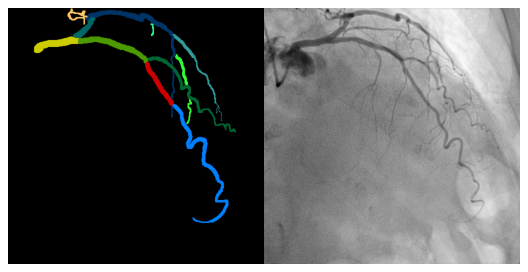

In [114]:
draw_mask_and_image(image, my_mask)


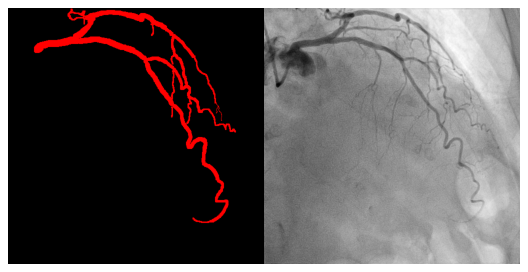

In [115]:
draw_mask_and_image(image_binary, my_mask_binary)

In [187]:
# Leave comented out, it is for checking the difference between binary and normal mask

# # change both to one and same color
# mask = np.copy(my_mask)
# mask_binary = np.copy(my_mask_binary)
# mask_binary = np.round(mask_binary * 255).astype(np.uint8)
# for i in range(mask.shape[0]):
#         for j in range(mask.shape[1]):
#                 if sum(mask[i, j]) > 0:
#                         # set to red
#                         mask[i, j] = [255, 0, 0]
# print(np.unique(mask))
# print(np.unique(mask_binary))
# diff = np.abs(mask - mask_binary)
# print(np.unique(diff))
# plt.imshow(diff)

# Extracting points using default library function

In [14]:
#prepare the masks
mask = np.copy(my_mask)
mask = np.round(mask * 255).astype(np.uint8)
mask_binary = np.copy(my_mask_binary)
mask_binary = np.round(mask_binary * 255).astype(np.uint8)

In [141]:
def get_keypoints_using_convolution(mask):
    # kernel = np.array([[0, 0, 1, 0, 0],
    #             [0, 1, 1, 1, 0],
    #             [1, 1, 10, 1, 1],
    #             [0, 1, 1, 1, 0],
    #             [0, 0, 1, 0, 0]])
    # Define a kernel
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    # Initialize a dictionary to store the keypoints
    keypoints_per_color = {}

    # Convert the mask to grayscale
    grayscale_mask = rgb2gray(mask)

    # Apply a threshold to create a binary mask of the boundaries
    binary_mask = grayscale_mask > 0

    # Apply skeletonization
    skeleton = skeletonize(binary_mask)

    # Convolve the skeleton with the kernel
    convolved = convolve2d(skeleton, kernel, mode='same')

    # Find keypoints (crossings, bifurcations)
    keypoints = np.where(convolved >= 13)

    # Store the keypoints
    keypoints_per_color['boundaries'] = keypoints

    return keypoints_per_color,skeleton,convolved


In [142]:
def draw_keypoints(image, keypoints, color=[255, 255, 255], radius=2):
    # Create a copy of the original image to draw on
    image_with_keypoints = np.copy(image)

    # Convert the image to RGB if it's grayscale
    if len(image_with_keypoints.shape) == 2:
        image_with_keypoints = np.stack([image_with_keypoints]*3, axis=-1)

    for y, x in zip(*keypoints):
        # Draw a red circle around each keypoint
        image_with_keypoints[max(y-radius, 0):min(y+radius, image_with_keypoints.shape[0]-1), 
                             max(x-radius, 0):min(x+radius, image_with_keypoints.shape[1]-1)] = color

    return image_with_keypoints

In [143]:
keypoints_per_color,skeleton,convolved = get_keypoints_using_convolution(my_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


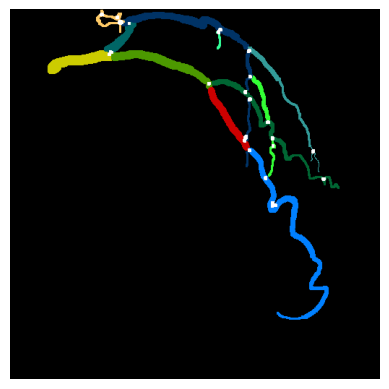

In [144]:
# Draw the keypoints on the mask
image_with_keypoints = draw_keypoints(my_mask, keypoints_per_color['boundaries'])

# Display the image with keypoints
plt.imshow(image_with_keypoints)
plt.axis("off")
plt.show()

# Extracting points using approach - colors crossing

In [145]:
def get_keypoints_using_neighbours(mask):
    keypoints_neighbours = {}
    # Convert the image to grayscale
    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Apply a Sobel filter to detect edges
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    edges = np.hypot(sobelx, sobely)

    # Threshold the result to create a binary mask of the edges
    _, binary_mask = cv2.threshold(edges, 100, 255, cv2.THRESH_BINARY)

    # Find the coordinates of the non-zero points in the binary mask
    keypoints = np.nonzero(binary_mask)

    # Create a lists to store the filtered keypoints
    filtered_keypoints_y = []
    filtered_keypoints_x = []

    # Iterate through each keypoint
    max_range = 2
    for y, x in zip(*keypoints):
        # Get the neighboring pixels
        neighbors = mask[max(y-max_range, 0):min(y+max_range+1, mask.shape[0]), max(x-max_range, 0):min(x+max_range+1, mask.shape[1])]
        exclude = False
        for i in range(neighbors.shape[0]):
            for j in range(neighbors.shape[1]):
                # if sum equals to 0, exclude
                if np.sum(neighbors[i][j]) == 0:
                    exclude = True
                    break
            if exclude:
                break
        if exclude:
            continue
        
        # Store the keypoint
        filtered_keypoints_y.append(y)
        filtered_keypoints_x.append(x)

    # Store the filtered keypoints
    filtered_keypoints = (np.array(filtered_keypoints_y), np.array(filtered_keypoints_x))
    keypoints_neighbours['boundaries'] = filtered_keypoints

    return keypoints_neighbours

In [146]:
filtered_keypoints = get_keypoints_using_neighbours(mask)

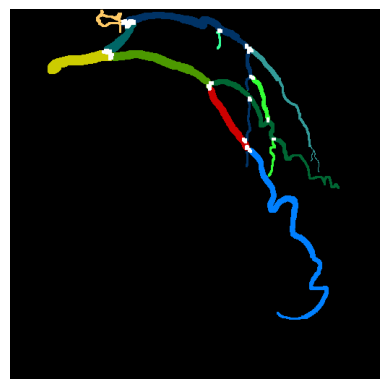

In [147]:
# draw using function
image_with_keypoints = draw_keypoints(mask, filtered_keypoints['boundaries'])

# Display the image with keypoints
plt.imshow(image_with_keypoints)
plt.axis("off")
plt.show()

In [148]:
from sklearn.cluster import DBSCAN

def group_keypoints(keypoints, eps=3, min_samples=2):
    # Keypoints shape is tuple(np.array(y), np.array(x))
    # Convert the dict of keypoints to an array
    keypoints_grouped = {}

    keypoints_array = np.stack([keypoints['boundaries'][1], keypoints['boundaries'][0]], axis=-1)

    # Apply DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(keypoints_array)

    # Get the labels of the clusters
    labels = clustering.labels_

    # Initialize a list to store the representative points
    representative_x = []
    representative_y = []

    # Iterate over each cluster
    for i in set(labels):
        # If the label is -1, the point is an outlier, so skip it
        if i == -1:
            continue

        # Get the points in the current cluster
        cluster_points = keypoints_array[labels == i]

        # Select a representative point from the cluster
        # Here, we select the point closest to the centroid of the cluster
        centroid = cluster_points.mean(axis=0)
        representative_point = cluster_points[np.argmin(np.sum((cluster_points - centroid)**2, axis=1))]

        # Add the representative point to the list
        representative_y.append(representative_point[1])
        representative_x.append(representative_point[0])
    
    # Store the representative points
    representative_points = (np.array(representative_y), np.array(representative_x))

    keypoints_grouped['boundaries'] = representative_points

    return keypoints_grouped


In [149]:
keypoints_per_color = group_keypoints(filtered_keypoints)

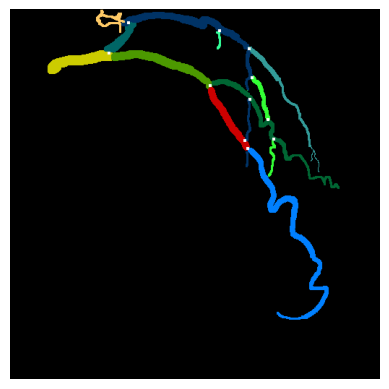

In [150]:
image_with_keypoints = draw_keypoints(mask, keypoints_per_color['boundaries'])

plt.imshow(image_with_keypoints)
plt.axis("off")
plt.show()

## Visualization

In [151]:
def get_close_up(image, original_image, keypoint, size=64):
    y, x = keypoint
    half_size = size // 2

    # Calculate the boundaries of the close-up
    top = max(0, y - half_size)
    bottom = min(image.shape[0], y + half_size)
    left = max(0, x - half_size)
    right = min(image.shape[1], x + half_size)

    # Extract the close-up from the image
    close_up = image[top:bottom, left:right]

    # Extract the close-up from the original image
    original_close_up = original_image[top:bottom, left:right]

    return close_up, original_close_up

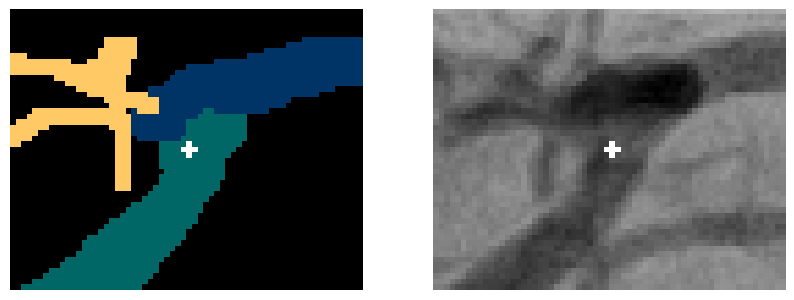

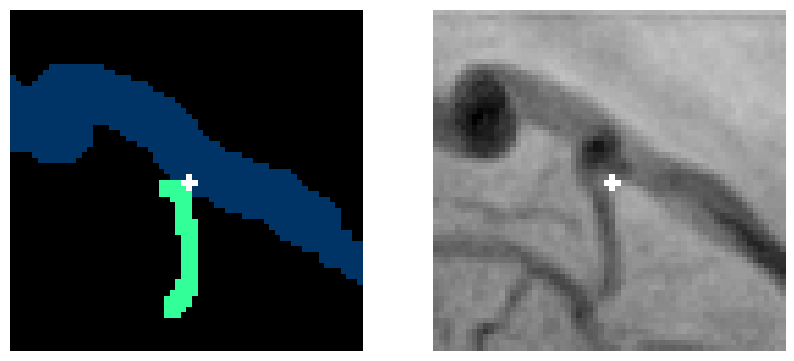

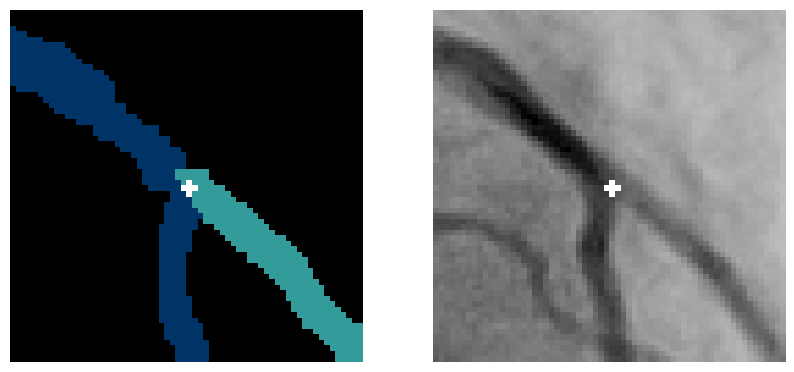

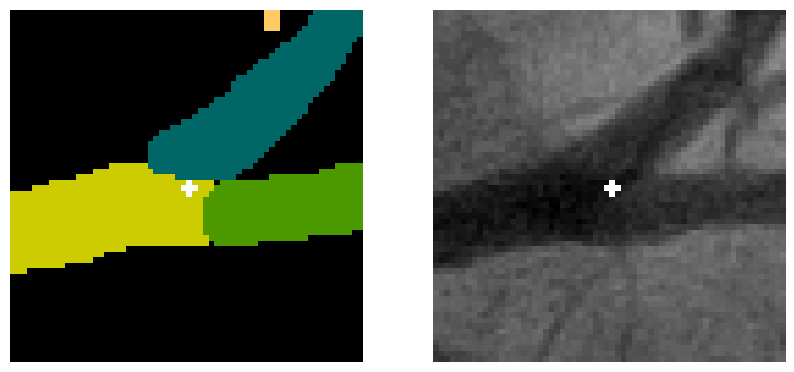

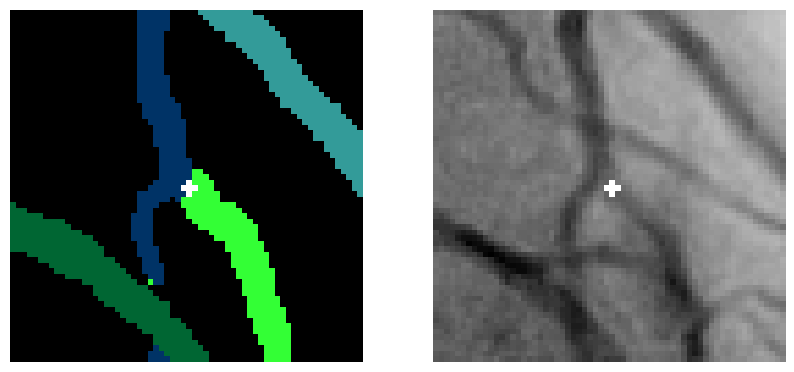

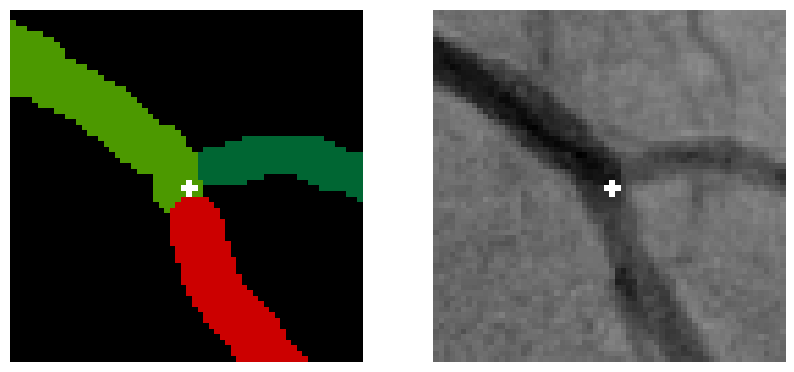

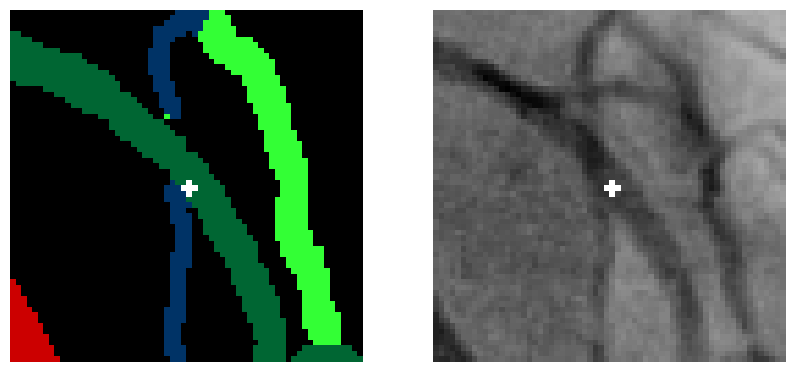

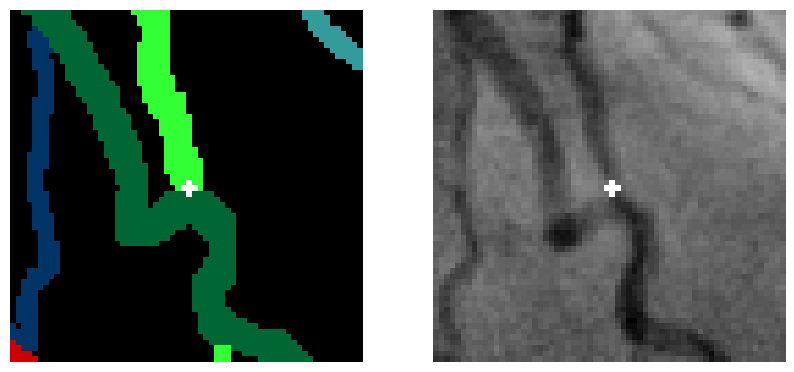

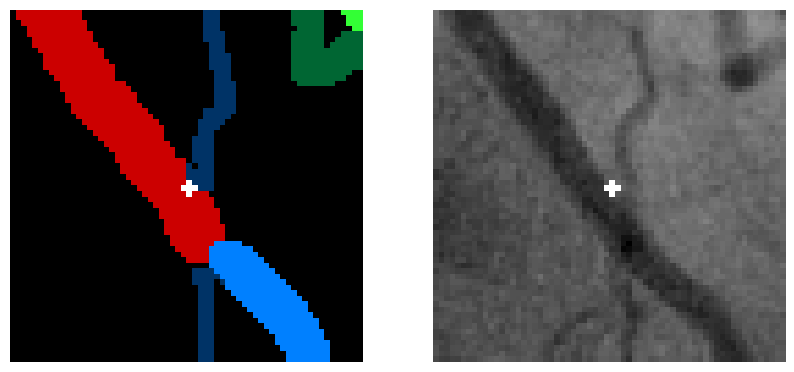

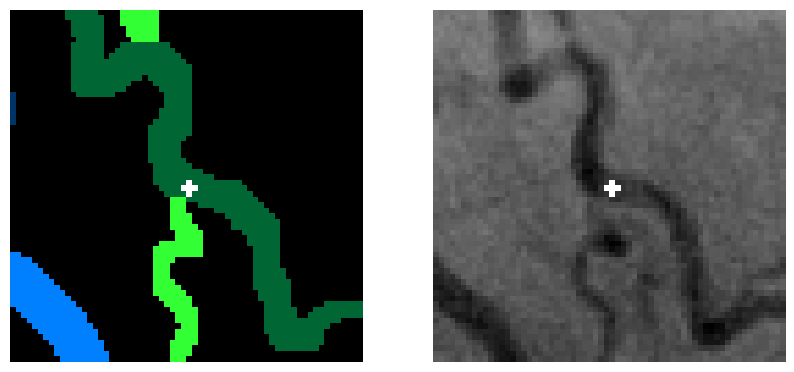

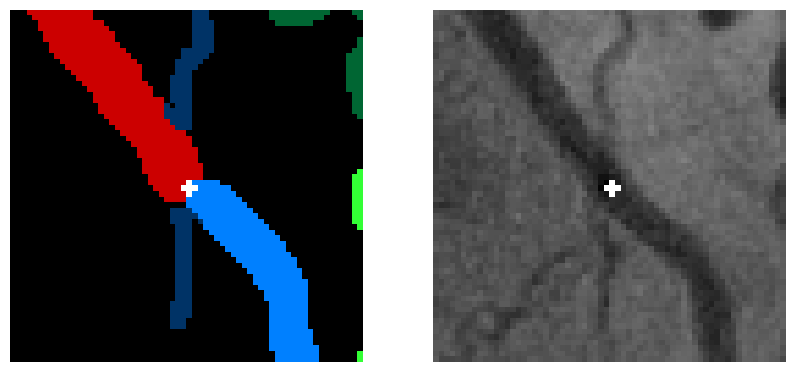

In [152]:
for keypoint in zip(*keypoints_per_color['boundaries']):
    close_up, original_close_up = get_close_up(mask, image, keypoint)

    # Calculate the location of the keypoint in the close-up
    close_up_keypoint = (close_up.shape[1] // 2, close_up.shape[0] // 2)

    # Draw the keypoint on the close-ups
    close_up_with_keypoint = cv2.circle(close_up.copy(), close_up_keypoint, radius=1, color=(255, 255, 255), thickness=-1)
    original_close_up_with_keypoint = cv2.circle(original_close_up.copy(), close_up_keypoint, radius=1, color=(255, 255, 255), thickness=-1)

    # Create a 1x2 grid of plots
    plt.figure(figsize=(10, 5))

    # Draw the close-up from the mask with the keypoint
    plt.subplot(1, 2, 1)
    plt.imshow(close_up_with_keypoint, cmap='gray')
    plt.axis('off')

    # Draw the close-up from the original image with the keypoint
    plt.subplot(1, 2, 2)
    plt.imshow(original_close_up_with_keypoint, cmap='gray')
    plt.axis('off')

    plt.show()

# Skeletonization and finding bifurcation with it

Using skeletonization and nx.graphs i try to find bifurcation, filter-out noise and differentiate branches and crossing

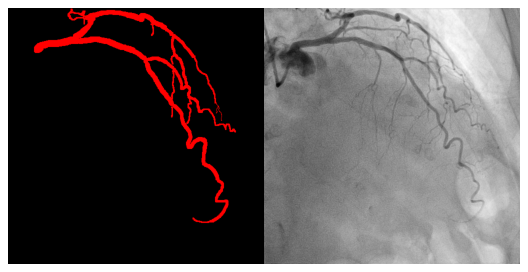

In [198]:
index_binary = 8
image_binary = images_voting[index_binary]
my_mask_binary = get_mask(images_voting[index_binary], segmentations_voting[index_binary], labels_voting[index_binary], name=filenames_voting[index_binary], folder_name='ground_truth', binary=True, ground_truth=True)
clear_output(wait=True)
draw_mask_and_image(image_binary, my_mask_binary)

In [7]:
mask_binary = np.copy(my_mask_binary)
mask_binary = np.round(mask_binary * 255).astype(np.uint8)

(-0.5, 511.5, 511.5, -0.5)

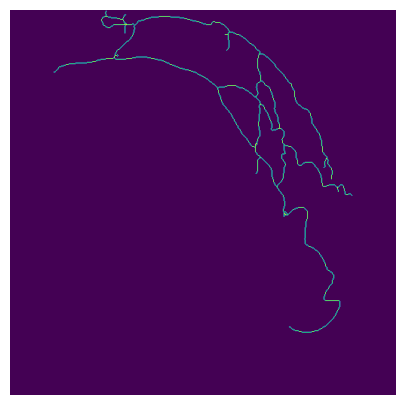

In [8]:
import networkx as nx
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage import img_as_ubyte
from skimage.io import imread
from skan import summarize, csr

def get_skeleton_from_mask(mask):
    # Convert the mask to grayscale
    grayscale_mask = rgb2gray(mask)

    # Apply a threshold to create a binary mask of the boundaries
    binary_mask = grayscale_mask > 0

    # Apply skeletonization
    skeleton = skeletonize(binary_mask)

    return skeleton

skeleton_binary = get_skeleton_from_mask(my_mask_binary)
# skeleton = get_skeleton_from_mask(my_mask)

# draw both
plt.figure(figsize=(10, 5))

plt.subplot(1, 1, 1)
plt.imshow(skeleton_binary)
plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(skeleton)
# plt.axis('off')

# show diff between the two
# diff = np.logical_xor(skeleton, skeleton_bin)
# plt.imshow(diff)

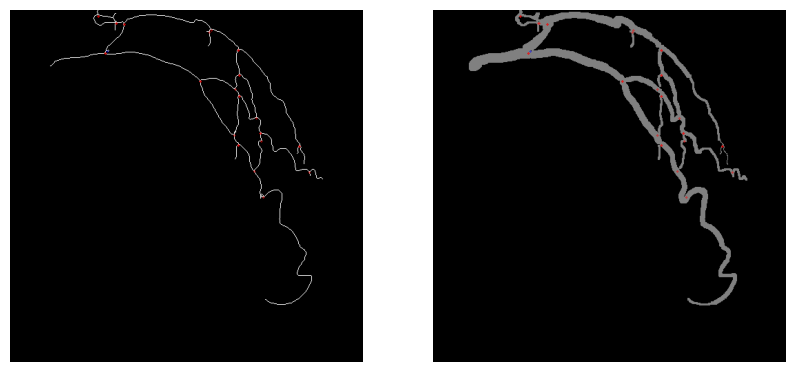

In [14]:
from skan import csr, summarize,draw,_testdata
from matplotlib.colors import LinearSegmentedColormap

# Create a custom color map that goes from black to light gray
cmap = LinearSegmentedColormap.from_list('my_cmap', ['black', 'gray'])


def get_keypoints_from_skeleton(skeleton):
     # Convert the skeleton to a graph and get the coordinates
    csr_skeleton = csr.Skeleton(skeleton)
    pixel_graph, coordinates = csr.skeleton_to_csgraph(skeleton)

    # Create a NetworkX graph from the csgraph
    G = nx.from_scipy_sparse_array(pixel_graph)

    # Get the summary of the skeleton
    branch_data = summarize(csr_skeleton)

    # Initialize a list to store the keypoints
    keypoints = []

    coordinates_array = np.array(coordinates).T

    keypoints_destination = []

    path_threshold = 10 # Threshold for the path length

    # Traverse the DataFrame and find the keypoints
    for _, row in branch_data.iterrows():
        src = (row['image-coord-src-0'],row['image-coord-src-1'])  # y, x
        dst = (row['image-coord-dst-0'],row['image-coord-dst-1'])  # y, x

        src_array = np.array(src)
        dst_array = np.array(dst)
        
        
        if any((coordinates_array == src_array).all(axis=1)) and any((coordinates_array == dst_array).all(axis=1)):
            src_index = np.where((coordinates_array == src_array).all(axis=1))[0][0]  # Get the index of src in coordinates
            dst_index = np.where((coordinates_array == dst_array).all(axis=1))[0][0]  # Get the index of dst in coordinates

            # Check if the degree of the nodes is greater than 2 (bifurcation or crossing)
            if G.degree[src_index] > 2:
                branch_distance = row['branch-distance']

                if branch_distance > path_threshold:
                    keypoints.append((src, "src"))
            
        # if row['node-id-dst'] == row['node-id-src']:
        #     keypoints.append((src, "special"))

        keypoints_destination.append({"src":src,"dst":dst})

    # print(keypoints)

    return keypoints,branch_data


keypoints_binary,branch_data = get_keypoints_from_skeleton(skeleton_binary)
# draw keypoints
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(skeleton_binary, cmap='gray')
axs[0].axis('off')

# Convert the 3-channel image to grayscale
gray_mask = cv2.cvtColor(mask_binary, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale image to get a binary image
binary_mask = np.where(gray_mask > 0, 1, 0)

# Display the binary mask in grayscale
axs[1].imshow(binary_mask, cmap=cmap)
axs[1].axis('off')

for keypoint in keypoints_binary:
    if keypoint[1] == "src":
        axs[0].scatter(keypoint[0][1], keypoint[0][0], c='r', s=0.1)
        axs[1].scatter(keypoint[0][1], keypoint[0][0], c='r', s=0.1)
    elif keypoint[1] == "special":
        axs[0].scatter(keypoint[0][1], keypoint[0][0], c='b', s=0.1)
        axs[1].scatter(keypoint[0][1], keypoint[0][0], c='b', s=0.1)
    

In [11]:
branch_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,0,12,7.828427,1,1.0,0.0,1,127,8,127,1,127,8,127,7.000000
1,0,7,98,8.242641,1,1.0,0.0,6,153,12,149,6,153,12,149,7.211103
2,0,12,186,48.384776,2,1.0,0.0,8,127,19,152,8,127,19,152,27.313001
3,0,12,98,23.656854,2,1.0,0.0,8,127,12,149,8,127,12,149,22.360680
4,0,98,150,6.242641,2,1.0,0.0,12,149,17,152,12,149,17,152,5.830952
5,0,150,151,1.000000,1,1.0,0.0,17,152,17,153,17,152,17,153,1.000000
6,0,150,186,2.000000,2,1.0,0.0,17,152,19,152,17,152,19,152,2.000000
7,0,159,188,1.000000,1,1.0,0.0,18,154,19,154,18,154,19,154,1.000000
8,0,186,187,1.000000,2,1.0,0.0,19,152,19,153,19,152,19,153,1.000000
9,0,187,188,1.000000,2,1.0,0.0,19,153,19,154,19,153,19,154,1.000000
